In [551]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix



In [552]:
df =  pd.read_csv('../2017_07_07/TADPOLE_D1_D2.csv',low_memory=False,header = 0)

In [553]:
#Name of the columns
df.head(0)


,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,VERSION_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,FLDSTRENG_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,LONISID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,LONIUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,IMAGEUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,RUNDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,STATUS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP1_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP2_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP3_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP4_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP5_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP6_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP7_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BASETP8_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,OVERALLQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,TEMPQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,FRONTQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,PARQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,INSULAQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,OCCQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,BGQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,CWMQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,VENTQC_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST100SV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST101SV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST102TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST103TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST104TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST105TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST106TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST107TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST108TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST109TS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST10CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110CV_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110SA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110TA_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16,ST110TS_UCSFFSL_02_01

In [554]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Columns: 1907 entries, RID to update_stamp_UPENNBIOMK9_04_19_17
dtypes: float64(72), int64(8), object(1827)
memory usage: 185.4+ MB


In [555]:
#Do some test on the df
print(df['DX_bl'].unique())

['CN' 'AD' 'LMCI' 'EMCI' 'SMC']


In [556]:
#Check the values in the DX column
df['DX'].unique()

array(['NL', 'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia',
       'MCI to NL', 'Dementia to MCI', nan, 'NL to Dementia'],
      dtype=object)

In [557]:
pd.set_option('display.max_columns', None)

In [558]:
print(df.shape)

#Convert to numeric
df['PTGENDER']= df['PTGENDER'].replace(['Male','Female'],[1,0])
df['APOE4']= df['APOE4'].astype(float)
df['AGE']= df['AGE'].astype(float)
df['PTETHCAT']= df['PTETHCAT'].replace(['Hisp/Latino','Not Hisp/Latino','Unknown'],[2,1,0]).astype(int)
df['PTMARRY']= df['PTMARRY'].replace(['Married','Widowed','Divorced','Never married','Unknown'],[0,1,2,3,4]).astype(int)
df['PTRACCAT'] = df['PTRACCAT'].replace(['White','More than one','Black','Asian', 'Am Indian/Alaskan','Hawaiian/Other PI', 'Unknown'],[0,1,2,3,4,5,6]).astype(int)
df['DX_bl'] = df['DX_bl'].replace(['CN' ,'AD' ,'LMCI' ,'EMCI' ,'SMC'],['0','1','2','3','4']).astype(int)
df['DX'] = df['DX'].replace(['NL' ,'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia', 'MCI to NL','Dementia to MCI' ,'NL to Dementia'],['1','3','4','5','6','7','8','9'])
df['DX']=df['DX'].fillna(0)
df['DX'] = df['DX'].astype(int)

df['EXAMDATE_bl'] = pd.to_datetime(df['EXAMDATE_bl']).dt.strftime("%Y%m%d").astype(int)
print(df['EXAMDATE_bl'].head(1))

df['EXAMDATE'] = pd.to_datetime(df['EXAMDATE']).dt.strftime("%Y%m%d").astype(int)
print(df['EXAMDATE'].head(1))

#Print some df to check if it is correct
print(df['DX'].head(1))
print(df['DX'].unique())

# drop the columns in df they ate objet type
df = df.select_dtypes(exclude=['object'])
print(df.shape)


(12741, 1907)
0    20050908
Name: EXAMDATE_bl, dtype: int32
0    20050908
Name: EXAMDATE, dtype: int32
0    1
Name: DX, dtype: int32
[1 3 4 5 6 7 8 0 9]
(12741, 88)


The main measures to be predicted: DX, ADAS13, Ventricles
Cognitive tests: CDRSB, ADAS11, MMSE, RAVLT_immediate
MRI measures: Hippocampus, WholeBrain, Entorhinal, MidTemp
PET measures: FDG, AV45
CSF measures: ABETA_UPENNBIOMK9_04_19_17  (amyloid-beta level in CSF), TAU_UPENNBIOMK9_04_19_17 (tau level), PTAU_UPENNBIOMK9_04_19_17 (phosphorylated tau level)
Risk factors: APOE4, AGE

In [559]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RID                       12741 non-null  int64  
 1   SITE                      12741 non-null  int64  
 2   D1                        12741 non-null  int64  
 3   D2                        12741 non-null  int64  
 4   EXAMDATE                  12741 non-null  int32  
 5   DX_bl                     12741 non-null  int32  
 6   DXCHANGE                  8892 non-null   float64
 7   AGE                       12741 non-null  float64
 8   PTGENDER                  12741 non-null  int64  
 9   PTEDUCAT                  12741 non-null  int64  
 10  PTETHCAT                  12741 non-null  int32  
 11  PTRACCAT                  12741 non-null  int32  
 12  PTMARRY                   12741 non-null  int32  
 13  APOE4                     12729 non-null  float64
 14  FDG   

In [560]:


#Drop the columns that are not needed
df.shape
df = df.drop(['D1','D2','SITE','EXAMDATE','PIB','FDG','RID','Month','M','Month_bl','Years_bl'],axis=1)


In [561]:

#f = df[['ADAS11','ADAS13','AGE','APOE4','DX_bl','PTGENDER','WholeBrain','Ventricles','Hippocampus','PTRACCAT','DX_bl','DX']]

In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DX_bl                     12741 non-null  int32  
 1   DXCHANGE                  8892 non-null   float64
 2   AGE                       12741 non-null  float64
 3   PTGENDER                  12741 non-null  int64  
 4   PTEDUCAT                  12741 non-null  int64  
 5   PTETHCAT                  12741 non-null  int32  
 6   PTRACCAT                  12741 non-null  int32  
 7   PTMARRY                   12741 non-null  int32  
 8   APOE4                     12729 non-null  float64
 9   AV45                      2118 non-null   float64
 10  CDRSB                     8963 non-null   float64
 11  ADAS11                    8910 non-null   float64
 12  ADAS13                    8824 non-null   float64
 13  MMSE                      8932 non-null   float64
 14  RAVLT_

In [563]:
df['DX_bl'].unique()

array([0, 1, 2, 3, 4])

In [564]:
# Algorithme des k plus proches voisins
from sklearn.feature_selection import SelectFromModel


model = KNeighborsClassifier()
y = df['DX_bl']
X = df.drop(['DX_bl'],axis=1)


#delete bl
y = np.nan_to_num(y)
X= np.nan_to_num(X)
X.shape


(12741, 76)

In [565]:

#Split the df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

model.fit(X_train,y_train)

print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.8577892695539754
0.74581589958159


In [574]:
#Take the best parameters for the model

param_grid = {'n_neighbors': np.arange(1, 10),'metric': ['euclidean', 'manhattan']}
cv = cv =  StratifiedKFold(5)
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv)
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [575]:
# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
model = grid.best_estimator_
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

{'metric': 'manhattan', 'n_neighbors': 1}
0.9069171470063271
KNeighborsClassifier(metric='manhattan', n_neighbors=1)
1.0
0.9346234309623431


In [576]:
#View the error of the model

confusion_matrix(y_test, model.predict(X_test))


array([[570,   2,  11,   5,   2],
       [ 23, 166,  18,   5,   0],
       [  9,  20, 694,   5,   0],
       [  6,   3,   5, 323,   0],
       [  4,   2,   1,   4,  34]], dtype=int64)

In [577]:
#the learning curve
N, train_score,val_score = learning_curve(model,X_train,y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

[1732 3465 5197 6930 8663]


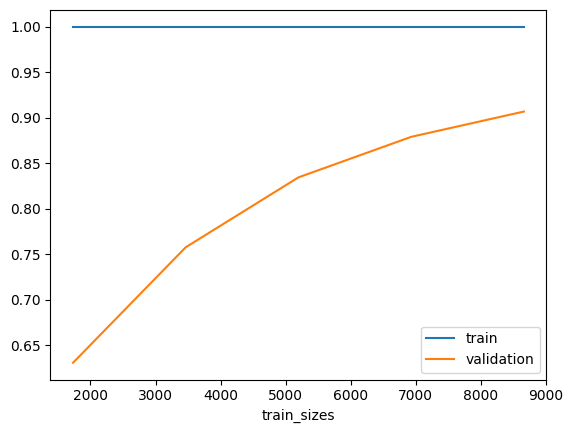

In [578]:
#Plot the learning curve
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()


In [579]:
#Chose the best split for the df
cv =  GroupKFold(5).get_n_splits(X,y,groups=X[:,9])
cross_val_score(model,X,y,cv=cv)

array([0.64809729, 0.71389325, 0.79434851, 0.72370487, 0.62951334])

In [580]:
cv= StratifiedKFold(5)
cross_val_score(model,X,y,cv=cv)

array([0.64809729, 0.71389325, 0.79434851, 0.72370487, 0.62951334])